In [2]:
import numpy as np
import xarray as xr
import itertools
import matplotlib.pyplot as plt
from cartopy import geodesic
import cartopy.crs as ccrs
import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import analysis_functions as funk
import cartopy.feature as cfeature
from cycler import cycler

from scipy.stats import kde

In [47]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

# simulations = [10] + [i for i in range(100, 501, 100)]
simulations = [100, 1000, 10000, 23000]

In [48]:
surface_events = np.load('../data/surface_events.npy', allow_pickle=True).item()

In [49]:
ds = pd.read_csv('../data/size_distribution_surface.csv', index_col=0)

In [51]:
mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/PSY4V3R1_mask.nc')
indices = {'lat': range(500, 1600), 'lon': range(2000, 4300)}
landmask = mask['tmask'][0, 0, indices['lat'], indices['lon']]
xlon = mask['nav_lon'][indices['lat'], indices['lon']].values
ylat = mask['nav_lat'][indices['lat'], indices['lon']].values

# mask the cell of the land == 0 
landmask = landmask.values
landmask = landmask.astype(float)
landmask = landmask[::10, ::10]
landmask[landmask == 0] = np.nan
ocean = np.isnan(landmask)
ocean = ocean.flatten()
xlon = xlon[::10, ::10]
ylat = ylat[::10, ::10]


/tmp/ipykernel_226607/762311612.py:15: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


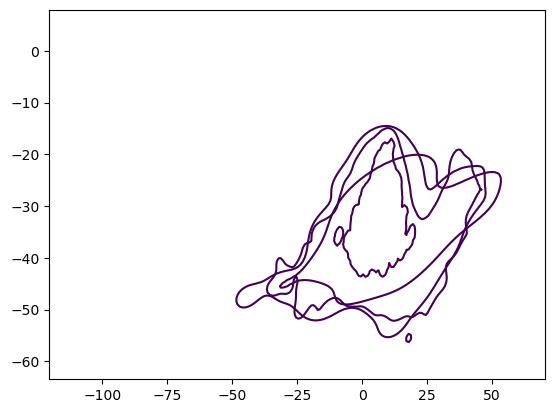

In [52]:
all_contours = {}
percentile = 0.9

xi, yi = xlon, ylat
XY = np.vstack([xi.flatten(), yi.flatten()])

ocean = ocean.flatten()
# XY = XY[:, ocean]

for j, ft in enumerate(simulations[::-1]):
    x = surface_events[ft]['lon']
    y = surface_events[ft]['lat']

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde([x, y])
    zi = k(XY)
    zi_masked = np.where(ocean, zi, np.nan)

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi_masked.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    cumulative_zi = cumulative_zi[~np.isnan(zi_sorted)]
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * (1 - percentile))[0][0]]

    # Plot contours at this density level
    contours = plt.contour(xi, yi, zi.reshape(xi.shape), levels=[level])
    
    # Get the contour lines
    largest_contour_line = None
    max_length = 0
    contour_lines = []
    for collection in contours.collections:
        for path in collection.get_paths():
            if len(path.vertices) > max_length:
                max_length = len(path.vertices)
                largest_contour_line = path.vertices
    all_contours[ft] = largest_contour_line 
    

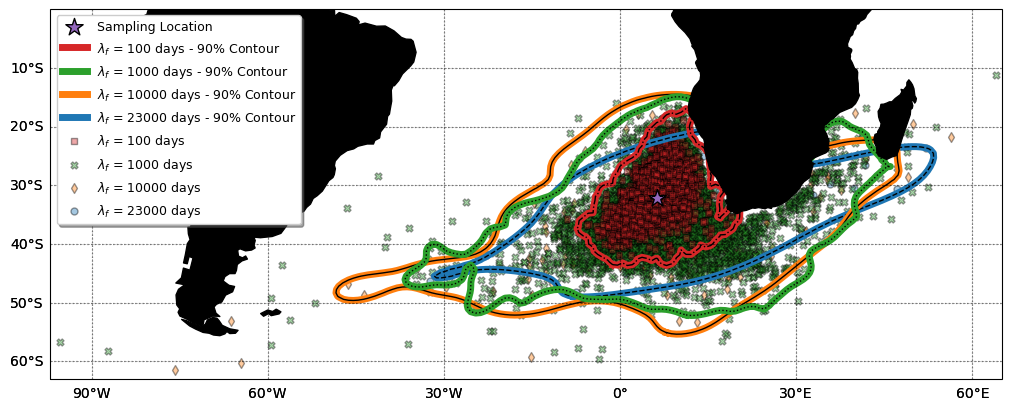

In [67]:
marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=5, color='black')
# ax.add_feature(cfeature.COASTLINE)

for j, ft in enumerate(simulations[::-1]):    
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=25, alpha=0.4, edgecolors='black',
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

for j, ft in enumerate(simulations[::-1]):  
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], label=f"$\lambda_f$ = {ft} days - {int(percentile*100)}% Contour",
            lw=5)
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], c='k',
            lw=1, ls=next(line_styles))

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')

# for r in range(1, 10, 2):
#     circle_points = geodesic.Geodesic().circle(lon=origin[0], lat=origin[1],
#                                                radius=r*1e6,
#                                                n_samples=360,
#                                                endpoint=False)
#     geom = shapely.geometry.Polygon(circle_points)
#     ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none',
#                       edgecolor='black', linewidth=1., zorder=3, ls='--',
#                       label=f'{r} km')
# ax.text(3.3, -24.5, r"$1,000$ km", fontsize=5)
# ax.text(-14.5, -30.5, r"$2,000$ km", fontsize=5, rotation=70)
# ax.text(-25., -30.5, r"$3,000$ km", fontsize=5, rotation=70)
# ax.text(-35.6, -30.5, r"$4,000$ km", fontsize=5, rotation=70)
# ax.text(-46.6, -31.5, r"$5,000$ km", fontsize=5, rotation=70)
# ax.text(-63.5, -48.5, r"$6,000$ km", fontsize=5, rotation=75)
# ax.text(-79.3, -52.5, r"$7,000$ km", fontsize=5, rotation=62)
# ax.text(-89.5, -45.3, r"$8,000$ km", fontsize=5, rotation=53)
# ax.text(-89.5, -27.3, r"$9,000$ km", fontsize=5, rotation=55)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]


ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left') 
fig.savefig('../article_figs/Figure3_v1.png', dpi=300,
            facecolor=(1, 0, 0, 0))

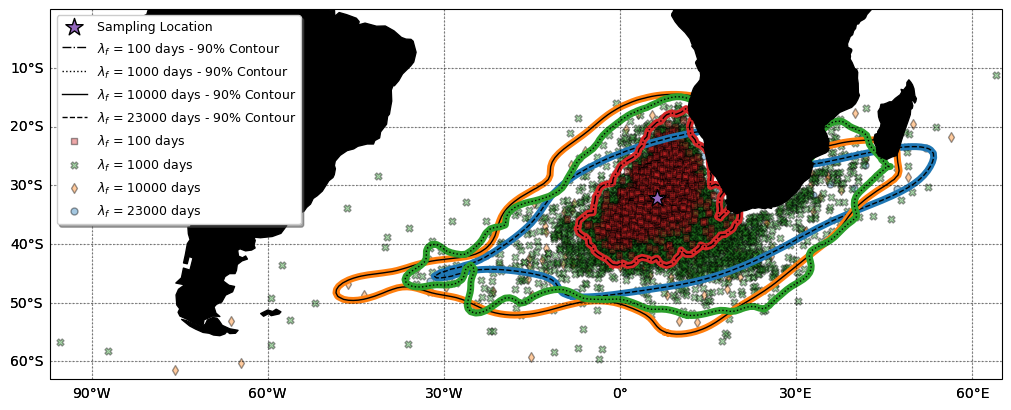

In [75]:
marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=5, color='black')
# ax.add_feature(cfeature.COASTLINE)

for j, ft in enumerate(simulations[::-1]):    
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=25, alpha=0.4, edgecolors='black',
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

for j, ft in enumerate(simulations[::-1]):  
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1],
            lw=5)
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], c='k',
            lw=1, ls=next(line_styles), label=f"$\lambda_f$ = {ft} days - {int(percentile*100)}% Contour")

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')

# for r in range(1, 10, 2):
#     circle_points = geodesic.Geodesic().circle(lon=origin[0], lat=origin[1],
#                                                radius=r*1e6,
#                                                n_samples=360,
#                                                endpoint=False)
#     geom = shapely.geometry.Polygon(circle_points)
#     ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none',
#                       edgecolor='black', linewidth=1., zorder=3, ls='--',
#                       label=f'{r} km')
# ax.text(3.3, -24.5, r"$1,000$ km", fontsize=5)
# ax.text(-14.5, -30.5, r"$2,000$ km", fontsize=5, rotation=70)
# ax.text(-25., -30.5, r"$3,000$ km", fontsize=5, rotation=70)
# ax.text(-35.6, -30.5, r"$4,000$ km", fontsize=5, rotation=70)
# ax.text(-46.6, -31.5, r"$5,000$ km", fontsize=5, rotation=70)
# ax.text(-63.5, -48.5, r"$6,000$ km", fontsize=5, rotation=75)
# ax.text(-79.3, -52.5, r"$7,000$ km", fontsize=5, rotation=62)
# ax.text(-89.5, -45.3, r"$8,000$ km", fontsize=5, rotation=53)
# ax.text(-89.5, -27.3, r"$9,000$ km", fontsize=5, rotation=55)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]


ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

legend = ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left')

fig.savefig('../article_figs/Figure3_v2.png', dpi=300,
            transparent=True)

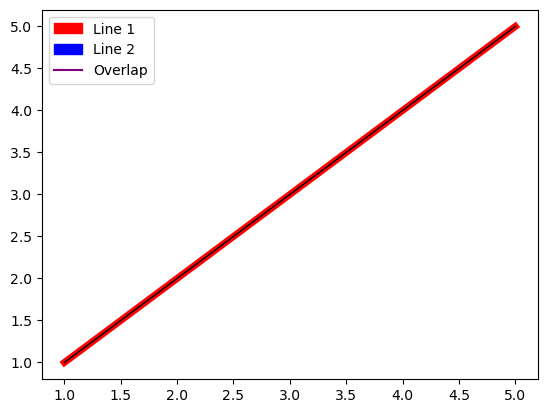

In [33]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Create some data
x = [1, 2, 3, 4, 5]
y1 = [1, 2, 3, 4, 5]
y2 = [2, 3, 4, 5, 6]

# Plot the lines
line1, = plt.plot(x, y1, color='red', label='Line 1', lw = 5)
line2, = plt.plot(x, y1, color='black', label='Line 2', lw = 1)

# Create a legend
red_patch = mpatches.Patch(color='red', label='Line 1')
blue_patch = mpatches.Patch(color='blue', label='Line 2')
purple_line = mlines.Line2D([], [], color='purple', label='Overlap')

plt.legend(handles=[red_patch, blue_patch, purple_line])


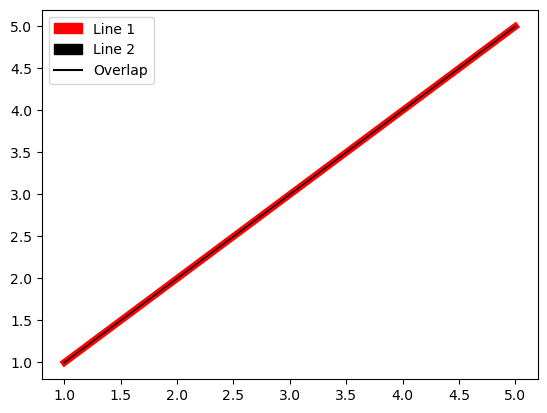

In [34]:
# Your existing plot commands
line1, = plt.plot(x, y1, color='red', label='Line 1', lw = 5)
line2, = plt.plot(x, y1, color='black', label='Line 2', lw = 1)

# Create a legend
red_patch = mpatches.Patch(color='red', label='Line 1')
black_patch = mpatches.Patch(color='black', label='Line 2')
overlap_line = mlines.Line2D([], [], color='black', label='Overlap')

plt.legend(handles=[red_patch, black_patch, overlap_line])

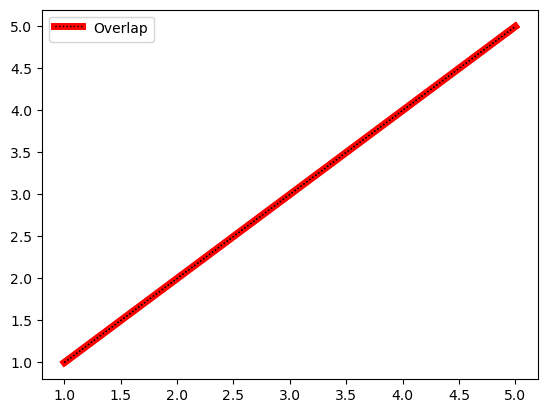

In [45]:
import matplotlib.patheffects as PathEffects

# Your existing plot commands
line1, = plt.plot(x, y1, color='red', label='Line 1', lw = 5)
line2, = plt.plot(x, y1, color='black', label='Line 2', lw = 1, linestyle=':')

# Add path effects to the lines
line1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='red')])
line2.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])

# Create a custom legend handler
class CustomHandler(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create a red line with a black dotted line on top
        l1 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='red', linewidth=5)
        l2 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='black', linewidth=1, linestyle=':')
        return [l1, l2]

# Create a legend
red_black_line = mlines.Line2D([], [], color='red', linewidth=5, label='Overlap')
plt.legend(handles=[red_black_line], handler_map={red_black_line: CustomHandler()})

plt.show()

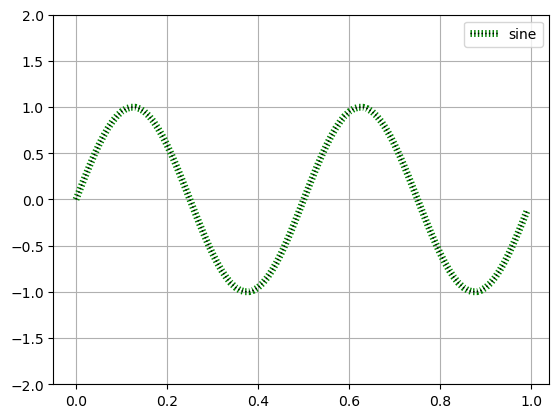

In [64]:
import matplotlib.patheffects as pe
 
# setup data
x = np.arange(0.0, 1.0, 0.01)
y = np.sin(2*2*np.pi*x)
 
# create line plot including an outline (stroke) using path_effects
plt.plot(x, y, color='k', lw=1, ls=':', path_effects=[pe.Stroke(linewidth=5, foreground='g'), pe.Normal()], label='sine')
# custom plot settings
plt.grid(True)
plt.ylim((-2, 2))
plt.legend()
plt.show()

In [ ]:
# Create a custom legend handler
class CustomHandler(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create a red line with a black dotted line on top
        l1 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='red', linewidth=5)
        
        l2 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='black', linewidth=1, linestyle=':')
        return [l1, l2]


NameError: name 'color' is not defined

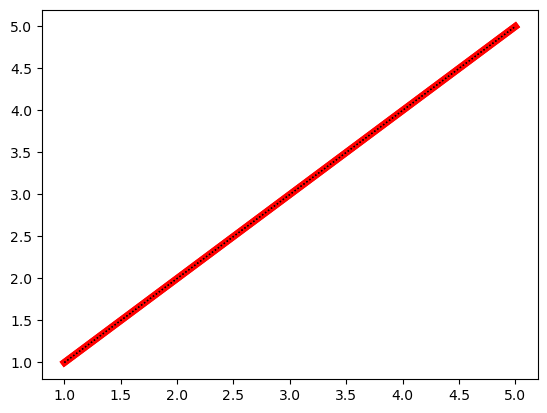

In [32]:
import matplotlib.patheffects as PathEffects

# Your existing plot commands
line1, = plt.plot(x, y1, color='red', label='Line 1', lw = 5)
line2, = plt.plot(x, y1, color='black', label='Line 2', lw = 1, linestyle=':')

# Add path effects to the lines
line1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='red')])
line2.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])


# Create a legend
red_black_line = mlines.Line2D([], [], color='red', linewidth=5, label='Overlap')
plt.legend(handles=[red_black_line], handler_map={red_black_line: CustomHandler()})

plt.show()

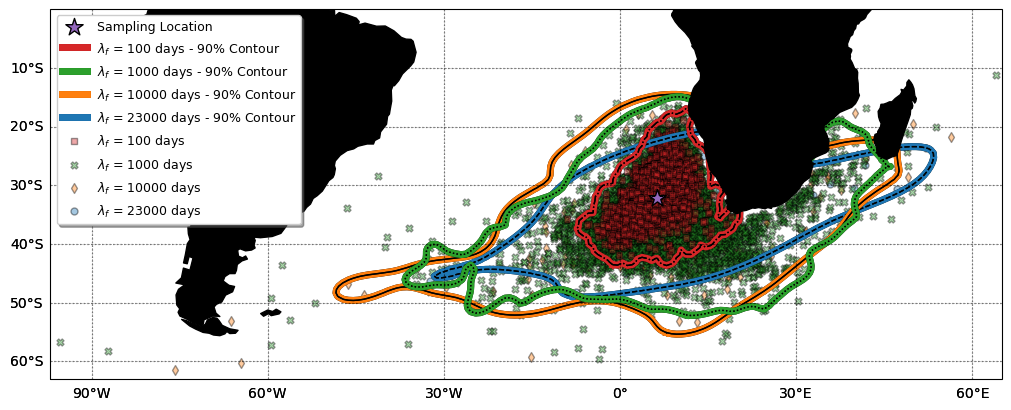

In [53]:
import matplotlib.patheffects as PathEffects

marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cfeature.LAND, zorder=5, color='black')

for j, ft in enumerate(simulations[::-1]):    
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=25, alpha=0.4, edgecolors='black',
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

for j, ft in enumerate(simulations[::-1]):  
    line1, = ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], label=f"$\lambda_f$ = {ft} days - {int(percentile*100)}% Contour",
            lw=5)
    line2, = ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], c='k',
            lw=1, ls=next(line_styles))
    line1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='black')])
    line2.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left') 
fig.savefig('../article_figs/Figure3_candidate.png', dpi=300,
            facecolor=(1, 0, 0, 0))

In [65]:
class CustomHandler1(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create a red line with a black dotted line on top
        l1 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='red', linewidth=5)
        l2 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='black', linewidth=1, linestyle='-.')
        return [l1, l2]
    
class CustomHandler2(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create a red line with a black dotted line on top
        l1 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='green', linewidth=5)
        l2 = mlines.Line2D([xdescent + width, xdescent],
                           [0.7*height, 0.7*height],
                           color='black', linewidth=1, linestyle=':')
        return [l1, l2]
    
# class CustomHandler1(HandlerLine2D):
#     def create_artists(self, legend, orig_handle,
#                        xdescent, ydescent, width, height, fontsize, trans):
#         # Create a red line with a black dotted line on top
#         l1 = mlines.Line2D([xdescent + width, xdescent],
#                            [0.7*height, 0.7*height],
#                            color='red', linewidth=5)
#         l2 = mlines.Line2D([xdescent + width, xdescent],
#                            [0.7*height, 0.7*height],
#                            color='black', linewidth=1, linestyle=':')
#         return [l1, l2]
    
# class CustomHandler1(HandlerLine2D):
#     def create_artists(self, legend, orig_handle,
#                        xdescent, ydescent, width, height, fontsize, trans):
#         # Create a red line with a black dotted line on top
#         l1 = mlines.Line2D([xdescent + width, xdescent],
#                            [0.7*height, 0.7*height],
#                            color='red', linewidth=5)
#         l2 = mlines.Line2D([xdescent + width, xdescent],
#                            [0.7*height, 0.7*height],
#                            color='black', linewidth=1, linestyle=':')
#         return [l1, l2]

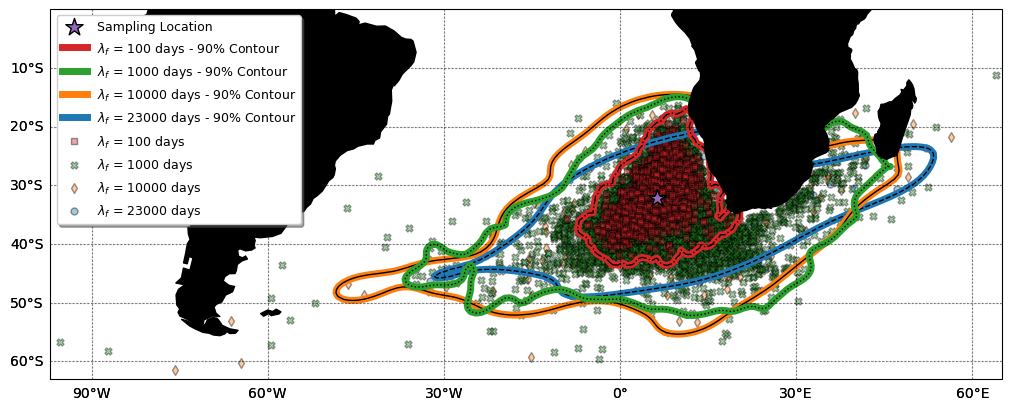

In [66]:
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerLine2D

marker = itertools.cycle(('o', 'd', 'X', 's'))
line_styles = itertools.cycle(['--', '-', ':', '-.'])

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cfeature.LAND, zorder=5, color='black')

for j, ft in enumerate(simulations[::-1]):    
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=25, alpha=0.4, edgecolors='black',
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

for j, ft in enumerate(simulations[::-1]):
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], label=f"$\lambda_f$ = {ft} days - {int(percentile*100)}% Contour",
            lw=5)
    ax.plot(all_contours[ft][:, 0], all_contours[ft][:, 1], c='k',
            lw=1, ls=next(line_styles))


ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=170, edgecolors='black')

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=1, fontsize=9, shadow=True, loc='upper left', handler_map={red_black_line: CustomHandler()}) 
# fig.savefig('../article_figs/Figure3_candidate.png', dpi=300,
#             facecolor=(1, 0, 0, 0))